# Step-by-Step Tree generation

## Run the together service and make sure you can prompt the model

In [149]:
import os
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import random
import re

In [187]:
class ProviderReq:
    def __init__(self, url, cache_path="./cache.jsonl", model=None):
        self.url = url
        self.cache = {}
        self.cache_path = cache_path
        self.model = model  # Default model is set to None, but can be overridden in child classes
        if os.path.exists(self.cache_path):
            with open(self.cache_path, "r") as f:
                for line in f:
                    datum = json.loads(line.strip())
                    self.cache[tuple(datum["input"])] = datum["response"]

    def req2provider(self, prompt, temperature=0, max_tokens=None, stop=None, logprobs=1, use_cache=True):
        assert isinstance(prompt, str)
        input = (prompt, self.model, max_tokens, stop, logprobs)
        if use_cache and temperature == 0 and input in self.cache:
            return self.cache[input], True

        # Retry logic
        for i in range(3):
            try:
                response = self.make_request(prompt, self.model, temperature, max_tokens, stop, logprobs)
                if response.status_code != 200:
                    raise Exception(response.text)
                break
            except Exception as e:
                err_msg = str(e)
                print(e)
                if "reduce your prompt" in err_msg:  # this is because the input string is too long
                    return ['too long'], False

        try:
            response_json = response.json()
            response = self.parse_response(response_json)
        except:
            return ['error'], False

        # Cache the result if temperature is 0
        if temperature == 0:
            self.cache_result(input, response)

        return response, True

    def make_request(self, prompt, model, temperature, max_tokens, stop, logprobs):
        """To be implemented in the subclass"""
        raise NotImplementedError("Subclasses should implement this method")

    def parse_response(self, response_json):
        """To be implemented in the subclass"""
        raise NotImplementedError("Subclasses should implement this method")

    def cache_result(self, input, response):
        """Cache the result if it's not already cached"""
        if input not in self.cache:
            self.cache[input] = response
            with open(self.cache_path, "a") as f:
                f.write("%s\n" % json.dumps({"input": input, "response": response}))

class TogetherReq(ProviderReq):
    # meta-llama/Llama-Vision-Free is free but doesnt support log_probs which are necessary for probtree
    # meta-llama/Meta-Llama-3-8B-Instruct-Turbo : bad answers but provide log_prob
    # meta-llama/Llama-3.2-3B-Instruct-Turbo ? bad answers tpp
    # meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo ? very nice but no log_prob !! 
    # meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo ? niceeee and log probs !! :) 
    # meta-llama/Meta-Llama-3-70B-Instruct-Lite ?
    def __init__(self, cache_path="./cache.jsonl", model="meta-llama/Meta-Llama-3-70B-Instruct-Lite"):
        super().__init__(url="http://127.0.0.1:10001/api/together/completion", cache_path=cache_path, model=model)

    def make_request(self, prompt, model, temperature, max_tokens, stop, logprobs):
        return requests.post(self.url, json={
            "model": model,
            "messages": [
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            "temperature": temperature,
            "max_tokens": max_tokens,
            "stop": stop,
            "logprobs": logprobs,
        })

    def parse_response(self, response_json):
        return response_json['choices']

def bm25_search(question, k, use_serpapi=False):
    web = "http://localhost:1439"
    data = {
        "query": question,
        "k": k
    }
    for i in range(3):
        try:
            r = requests.get(web, json=data)
            if r.status_code != 200:
                raise Exception(r.text)
            contexts = r.json()
            # if use_serpapi:
            #     context = get_question_wiki_snippet(question, cache=True)
            #     title = context.split(': ')[0]
            #     text = ' '.join(context.split(': ')[1:])
            #     contexts.append({"title": title, "text": text})
            return contexts
        except Exception as e:
            print(e)

In [188]:
from dotenv import load_dotenv
load_dotenv()

key_pool = os.getenv('TOGETHER_API_KEY').split(',')
NUM_WORKERS = len(key_pool)  # Match the number of workers to the number of clients

reqor = TogetherReq()
result, tag = reqor.req2provider("Hello, I am from Egypt. Guess my name ??", max_tokens = None, stop = None)
print(result[0])

{'finish_reason': 'eos', 'index': 0, 'logprobs': {'token_ids': [3923, 264, 27387, 8815, 2268, 81122, 1131, 13126, 499, 2351, 505, 15212, 11, 358, 3358, 1935, 264, 8545, 8101, 2195, 11787, 499, 8530, 7086, 330, 83705, 3690, 1, 477, 330, 6219, 81, 44969, 4314, 527, 1633, 4279, 5144, 304, 15212, 11, 719, 358, 1436, 387, 12756, 1022, 2268, 5618, 3041, 757, 264, 13310, 477, 3371, 757, 422, 358, 2846, 12660, 3345, 0, 128009], 'token_logprobs': [-0.1640625, -0.0024719238, -0.18945312, -0.46289062, -0.00074768066, -1.171875, -0.0017089844, -0.5546875, -0.21679688, -0.006713867, 0, -2.3841858e-07, -4.720688e-05, -0.0006942749, -0.47460938, -7.5101852e-06, -0.00033569336, -0.18554688, -0.011108398, -0.45117188, -0.640625, -0.00012302399, -0.578125, -0.19921875, -0.8515625, -0.49804688, -0.12695312, -0.1171875, -0.0007171631, -0.1171875, -0.875, -0.099609375, -0.11328125, -0.765625, -0.25195312, -0.76953125, -0.029785156, -0.12890625, 0, -1.0251999e-05, -0.026855469, -0.31445312, -0.005432129, -0

## Implementing the children decomposition mechanism to only expand/decompose one node at a time

In [189]:
# Function to create the prompt

# ***Carefully review the existing children and the current node. If they already provide a comprehensive decomposition of the current node and no further meaningful steps are needed, respond with "Done".***

# ***Only suggest a new child node if it directly contributes to solving the main question. The child node should be a specific, actionable step that helps answer the original question.***

# ***Important Rules:***
# 1. **Do not repeat subquestions**: Ensure the new child node does not repeat any of the existing children or restate information already present in the original question.
# 2. **Use placeholders correctly**: If the new child node depends on the answer of a previous subquestion, use placeholders like `<1>` to refer to it. For example:
# - If the first child is "What is the capital of France?", and the second child depends on its answer, write: "What is the population of <1>?"
# 3. **Avoid irrelevant subquestions**: Ensure the new child node directly contributes to solving the main question. Do not suggest subquestions that are unrelated or tangential.
# 4. **Keep subquestions simple and specific**: Avoid overly complex or redundant subquestions.

# ***Return only the new child node or "Done".***


def create_decompose_prompt(question, children):
    return f"""
    You are helping to decompose a complex question into smaller reasoning steps. Here is the current state of the tree:
    - Current Node: The main question that needs to be broken down into smaller steps.
    - Existing Children: A list of subquestions (thoughts) already generated to help answer the main question.

    ### Task:

    1. **Carefully analyze the reasoning tree**:
        - If the existing children fully address the current node and no further meaningful steps are needed, respond only with "Done"
        - If the current node needs further decomposition, suggest a single new child node that directly contributes to solving the main question.

    2. **Follow these rules for decomposition**:
        - **Focus on essential steps**: Suggest only subquestions that directly contribute to resolving the current node. Avoid peripheral details unless they are crucial.
        - **Avoid redundancy**: Do not repeat or rephrase existing children. Each new child node must add unique and meaningful information.
        - **Simplify complexity**: Keep subquestions clear and actionable. Avoid unnecessary depth unless it is required to make progress.
        - **Reference previous answers**: If a new child node depends on answers from previous children, use placeholders like `<1>`, `<2>`, etc., to reference them. For example:
            - If the first child is "How many members does The Border Surrender have?", you can reference its answer as `<1>`.
            - If the second child is "How many members does Unsane have?", you can reference its answer as `<2>`.

    3. **Define stopping criteria**:
        - Consider the decomposition complete if the existing children comprehensively address all aspects of the current node.
        - Do not over-decompose or create unnecessary subquestions by adding minor variations or excessive detail.
        - Respond with "Done" in that case when no further decomposition is needed.

    4. **Output Format**:
        - Return either the new child node or "Done" without any additional context.

    ---

    ### Examples for Guidance

    #### Example 1:
    - Current Node: "Does The Border Surrender or Unsane have more members?"
    - Existing Children: []
    - Response: "How many members does The Border Surrender have?"

    #### Example 2:
    - Current Node: "Does The Border Surrender or Unsane have more members?"
    - Existing Children: ["How many members does The Border Surrender have?"]
    - Response: "How many members does Unsane have?"

    #### Example 3:
    - Current Node: "Does The Border Surrender or Unsane have more members?"
    - Existing Children: ["How many members does The Border Surrender have?", "How many members does Unsane have?"]
    - Response: "Which is larger, <1> or <2>?"

    #### Example 4:
    - Current Node: "Does The Border Surrender or Unsane have more members?"
    - Existing Children: ["How many members does The Border Surrender have?", "How many members does Unsane have?", "Which is larger, <1> or <2>?"]
    - Response: "Done"

    ---

    - Current Node: {question}
    - Existing Children: {children}
    - Response:
    """


# Function to query the LLM
def query_llm(prompt):
    result, tag = reqor.req2provider(prompt, max_tokens=None, stop=None)
    response = result[0]["message"]["content"].strip()
    log_probs = result[0].get("logprobs", [])  # Assuming logprobs is returned by the LLM
    if log_probs:
        log_probs = log_probs["token_logprobs"]
    return response, log_probs

In [190]:
# Initialize the question and children
question = "Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?"
children = []

# Iterative decomposition loop until "Done" is returned
count = 0
while count < 3:  # Limiting the number of iterations for demonstration purposes
    # Create the prompt
    prompt = create_decompose_prompt(question, children)
    print("Prompt for expansion:", prompt)
    
    # Query the LLM
    response, log_probs = query_llm(prompt)
    print("LLM Response:", response)
    
    # Check if the response is "Done"
    if response.lower() == "done":
        print("Decomposition complete.")
        break
    
    # Add the new child node to the children list
    children.append(response)
    print("Updated Children:", children)

    count += 1

# Final tree structure
tree = {
    "node": question,
    "children": children
}
print("Final Tree:", tree)

Prompt for expansion: 
    You are helping to decompose a complex question into smaller reasoning steps. Here is the current state of the tree:
    - Current Node: The main question that needs to be broken down into smaller steps.
    - Existing Children: A list of subquestions (thoughts) already generated to help answer the main question.

    ### Task:

    1. **Carefully analyze the reasoning tree**:
        - If the existing children fully address the current node and no further meaningful steps are needed, respond only with "Done"
        - If the current node needs further decomposition, suggest a single new child node that directly contributes to solving the main question.

    2. **Follow these rules for decomposition**:
        - **Focus on essential steps**: Suggest only subquestions that directly contribute to resolving the current node. Avoid peripheral details unless they are crucial.
        - **Avoid redundancy**: Do not repeat or rephrase existing children. Each new chi

In [191]:
def get_all_children_of_certain_node(question, existing_children=[], max_children=3):
    # Iterative decomposition loop untill Done is got
    num_children = len(existing_children)
    while num_children <= max_children:
        # Create the prompt
        prompt = create_decompose_prompt(question, [child["text"] for child in existing_children])
        print("Prompt for expansion:", prompt)
        
        # Query the LLM
        response, log_probs = query_llm(prompt)
        print("LLM Response:", response)
        
        # Check if the response is "Done"
        if response.lower() == "done":
            print("Decomposition complete.")
            break
        
        # Calculate the score using log probabilities
        score = sum(log_probs) if log_probs else -100
        print("log_probs for the response:", log_probs)
        print("Score for the response:", score)

        # Add the new child node to the existing_children list
        existing_children.append({
            "text": response,
            "score": score,  # Keeping the original score for reference
            "log_probs_length": len(log_probs) if log_probs else -1,
        })
        print("Updated Children:", [child["text"] for child in existing_children])

    return existing_children

# Function to recursively decompose a node
def decompose_node(node, tree_structure={}, depth=0, max_depth=2):
    if depth >= max_depth:
        return tree_structure
    
    # Avoid re-decomposing the same node
    if node in tree_structure:
        return tree_structure

    children_with_scores = get_all_children_of_certain_node(node, [])
    print(f"Decomposition complete at depth {depth}.")

    # Add the new child node to the tree structure
    # TODO:: in original probtree code, score at parent was calculated based on response of one shot tree generation.
    # Here i added children sum scores, and lengths as lists since we generate each child now separately.
    tree_structure[node] = {
        "children": [child["text"] for child in children_with_scores],
        "children_sum_scores": [child["score"] for child in children_with_scores],
        "children_log_probs_lengths": [child["log_probs_length"] for child in children_with_scores],
    }
    assert len(tree_structure[node]["children"]) == len(tree_structure[node]["children_sum_scores"]) == len(tree_structure[node]["children_log_probs_lengths"]), "Length mismatch in children data."

    #TODO:: maybe can be removed since later we may need to decompose step by step or based on an action.
    # Recursively decompose the new child node
    for child in children_with_scores:
        tree_structure = decompose_node(child["text"], tree_structure, depth + 1, max_depth)

    return tree_structure

# Initialize the question and children
question = "Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?"

# Build the tree structure
tree_structure = {}
tree_structure = decompose_node(question, max_depth=1)

# Final tree structure
print("Final Tree Structure:", tree_structure)

Prompt for expansion: 
    You are helping to decompose a complex question into smaller reasoning steps. Here is the current state of the tree:
    - Current Node: The main question that needs to be broken down into smaller steps.
    - Existing Children: A list of subquestions (thoughts) already generated to help answer the main question.

    ### Task:

    1. **Carefully analyze the reasoning tree**:
        - If the existing children fully address the current node and no further meaningful steps are needed, respond only with "Done"
        - If the current node needs further decomposition, suggest a single new child node that directly contributes to solving the main question.

    2. **Follow these rules for decomposition**:
        - **Focus on essential steps**: Suggest only subquestions that directly contribute to resolving the current node. Avoid peripheral details unless they are crucial.
        - **Avoid redundancy**: Do not repeat or rephrase existing children. Each new chi

## Pruning Action 

In [192]:
def create_pruning_prompt(main_question, node, siblings):
    return f"""
    You are helping to prune a reasoning tree. Here is the current state of the tree:
    - Main Question: The root question that the reasoning tree is trying to answer.
    - Current Node: A subquestion or step in the reasoning process.
    - Siblings: Other subquestions or steps at the same level in the tree.

    ### Task:

    1. **Carefully analyze the reasoning tree**:
        - Evaluate whether the current node is relevant to solving the main question.
        - If the current node is irrelevant, redundant, or does not contribute meaningfully to solving the main question, respond with "Prune".
        - If the current node is relevant and necessary, respond with "Keep".

    2. **Follow these rules for pruning**:
        - **Focus on relevance**: A node should be pruned if it does not directly contribute to solving the main question.
        - **Avoid redundancy**: Prune nodes that repeat or rephrase existing information from siblings without adding new insights.
        - **Simplify complexity**: Prune nodes that introduce unnecessary complexity or depth without advancing the reasoning process.

    3. **Output Format**:
        - Return either "Prune" or "Keep" without any additional context.

    ---

    ### Examples for Guidance

    #### Example 1:
    - Main Question: "What is the capital of France?"
    - Current Node: "What is the population of Paris?"
    - Siblings: ["What is the name of the capital city of France?"]
    - Response: "Prune"  # Not directly relevant to the main question

    #### Example 2:
    - Main Question: "What is the capital of France?"
    - Current Node: "What is the name of the capital city of France?"
    - Siblings: ["What is the population of Paris?"]
    - Response: "Keep"  # Directly relevant to the main question

    #### Example 3:
    - Main Question: "What is the capital of France?"
    - Current Node: "What is the population of France?"
    - Siblings: ["What is the name of the capital city of France?"]
    - Response: "Prune"  # Not directly relevant to the main question

    #### Example 4:
    - Main Question: "What is the capital of France?"
    - Current Node: "What is the name of the capital city of France?"
    - Siblings: ["What is the population of France?"]
    - Response: "Keep"  # Directly relevant to the main question

    #### Example 5:
    - Main Question: "What is the capital of France?"
    - Current Node: "What is the population of Paris?"
    - Siblings: ["What is the name of the capital city of France?", "What is the population of France?"]
    - Response: "Prune"  # Redundant with siblings and not directly relevant

    ---

    - Main Question: {main_question}
    - Current Node: {node}
    - Siblings: {siblings}
    - Response:
    """

def should_prune_node(main_question, node, siblings):
    """
    Asks the LLM whether a node should be pruned.
    
    Args:
        main_question (str): The main question (root node).
        node (str): The node to evaluate.
    
    Returns:
        bool: True if the node should be pruned, False otherwise.
    """
    
    # Check if siblings contain the node, we should remove it but dont change the original list
    siblings = siblings.copy()
    if node in siblings:
        # print(f"Node '{node}' found in siblings. Removing it.")
        siblings.remove(node)

    # Create the pruning prompt
    prompt = create_pruning_prompt(main_question, node, siblings)
    # print("Prompt for pruning:", prompt)
    
    # Query the LLM
    response, _ = query_llm(prompt)
    
    # Parse the response
    return response.strip().lower() == "prune"

In [193]:
def prune_nodes_with_llm(question, tree_structure):
    # Extract the children, scores, and log probabilities from the tree structure
    children = tree_structure[question]['children']
    children_sum_scores = tree_structure[question]['children_sum_scores']
    children_log_probs_lengths = tree_structure[question]['children_log_probs_lengths']
    updated_children = children.copy()
    pruned_children = []

    # Create a mapping of child to its score and log probability length
    child_to_score = {child: score for child, score in zip(children, children_sum_scores)}
    child_to_log_prob = {child: log_prob for child, log_prob in zip(children, children_log_probs_lengths)}

    # Iterate through the children nodes and prune based on criteria
    for child in children:
        # Pass the score and log probability length indirectly via the updated_children list
        if should_prune_node(question, child, updated_children):
            pruned_children.append(child)
            updated_children.remove(child)
            print(f"Pruned node: {child}")

    updated_scores = [child_to_score[child] for child in updated_children]
    updated_log_probs = [child_to_log_prob[child] for child in updated_children]

    # Update the tree structure with the pruned results
    tree_structure[question]['children'] = updated_children
    tree_structure[question]['children_sum_scores'] = updated_scores
    tree_structure[question]['children_log_probs_lengths'] = updated_log_probs

    #TODO:: If the parent score depends on them, we must update the parent score as well. (Parent score based on children bot implemented yet)

    return tree_structure

# Example usage:
question = 'Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?'
tree_structure = {
    question: {
        'children': [
            'What was the typical page count of Weird Tales magazine during the 1930s?', 
            'Was Robert E. Howard a frequent contributor to Weird Tales magazine during the 1930s?', 
            'Was the fiction magazine in which Robert E. Howard wrote in 1930s primarily Weird Tales magazine?', 
            'If the fiction magazine in which Robert E. Howard wrote in 1930s was primarily Weird Tales magazine, did he write in other magazines during that period as well?', 
            'If the fiction magazine in which Robert E. Howard wrote in 1930s was not primarily Weird Tales magazine, what was the typical page count of that magazine during the 1930s?', 
            'What was the typical page count of other fiction magazines that Robert E. Howard wrote for during the 1930s?'
        ], 
        'children_sum_scores': [-2.04336368615382, -0.7338265208047, -5.4407544111175, -6.85595369407406, -0.95331907415425, -4.1018621915672], 
        'children_log_probs_lengths': [18, 20, 22, 35, 40, 25]
    }
}

# Prune nodes
updated_tree_structure = prune_nodes_with_llm(question, tree_structure)

print("Updated tree structure:", updated_tree_structure)

Pruned node: If the fiction magazine in which Robert E. Howard wrote in 1930s was primarily Weird Tales magazine, did he write in other magazines during that period as well?
Pruned node: If the fiction magazine in which Robert E. Howard wrote in 1930s was not primarily Weird Tales magazine, what was the typical page count of that magazine during the 1930s?
Pruned node: What was the typical page count of other fiction magazines that Robert E. Howard wrote for during the 1930s?
Updated tree structure: {'Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?': {'children': ['What was the typical page count of Weird Tales magazine during the 1930s?', 'Was Robert E. Howard a frequent contributor to Weird Tales magazine during the 1930s?', 'Was the fiction magazine in which Robert E. Howard wrote in 1930s primarily Weird Tales magazine?'], 'children_sum_scores': [-2.04336368615382, -0.7338265208047, -5.4407544111175], 'children_log_probs_lengths': [18

In [194]:
updated_tree_structure

{'Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?': {'children': ['What was the typical page count of Weird Tales magazine during the 1930s?',
   'Was Robert E. Howard a frequent contributor to Weird Tales magazine during the 1930s?',
   'Was the fiction magazine in which Robert E. Howard wrote in 1930s primarily Weird Tales magazine?'],
  'children_sum_scores': [-2.04336368615382,
   -0.7338265208047,
   -5.4407544111175],
  'children_log_probs_lengths': [18, 20, 22]}}

## Solving leaf nodes ?

# OOP Version 

In [217]:
class Node:
    def __init__(self, question, decomposition_log_probs=None, parent=None, placeholder=None):
        self.question = question  # The question or reasoning step
        self.placeholder = placeholder  # Placeholder for the answer
        self.children = []  # Child nodes (for decomposition)
        self.parent = parent  # Parent node
        self.decomposition_log_probs = decomposition_log_probs  # Confidence scores for decomposition, log probabilities
        self.solved = False  # Flag to indicate if the node has been solved
        self.cb_answer = None  # Answer from the closed-book model
        self.cb_log_probs = None  # Log probability from the closed-book model
        self.ob_answer = None  # Answer from the open-book model
        self.ob_log_probs = None  # Log probability from the open-book model
        self.child_aggregation_answer = None  # Aggregated answer from the children nodes
        self.child_aggregation_log_probs = None  # Aggregated log probabilities from the children nodes
        self.solver_results = []  # Store results from all solvers


    def add_child(self, child):
        """Add a child node."""
        if child.parent is not None and child.parent is not self:
            raise ValueError("The child node should not have a parent or should be the parent itself.")
        child.parent = self
        self.children.append(child)

    def __str__(self):
        """String representation of the node."""
        return f"Node(question={self.question}, children={[child.question for child in self.children]}, decomposition_log_probs={self.decomposition_log_probs})"

    def print_tree(self, level=0):
        """Print the tree structure."""
        print("  " * level + str(self))
        for child in self.children:
            child.print_tree(level + 1)
    
    def calculate_avg_log_probs(self, log_probs):
        if not log_probs:
            return -1000
        return sum(log_probs) / len(log_probs)
    
    def get_confident_children_sorted(self):
        return sorted(self.children, key=lambda child: child.calculate_avg_log_probs(child.decomposition_log_probs), reverse=True)
    
    def get_most_confident_child(self):
        return self.get_confident_children_sorted()[0]
    
    def is_parent_solved(self):
        """
        Check if the child node's answer resolves the parent node's question.
        """
        return self.parent.solved
    
    def return_best_answer(self):
        """
        Return the best answer for my node based on the confidence scores.
        """
        ob_score = self.calculate_avg_log_probs(self.ob_log_probs)
        cb_score = self.calculate_avg_log_probs(self.cb_log_probs)
        #TODO:: Child aggregation score is implemented differently in the original probtree code, they use scores from children nodes as well.
        child_aggreg_score = self.calculate_avg_log_probs(self.child_aggregation_log_probs)
        if ob_score >= cb_score and ob_score >= child_aggreg_score:
            return self.ob_answer
        elif cb_score >= ob_score and cb_score >= child_aggreg_score:
            return self.cb_answer
        else:
            return self.child_aggregation_answer
        
    def return_best_answer_score(self):
        """
        Return the best answer's score for my node based on the confidence scores.
        """
        ob_score = self.calculate_avg_log_probs(self.ob_log_probs)
        cb_score = self.calculate_avg_log_probs(self.cb_log_probs)
        child_aggreg_score = self.calculate_avg_log_probs(self.child_aggregation_log_probs)
        return max(ob_score, cb_score, child_aggreg_score)
    
    def get_solved_nodes_in_my_subtree(self):
        """
        Return a list of all nodes in the subtree rooted at the current node that are solved.
        """
        solved_nodes = []
        if self.solved:
            solved_nodes.append(self)
        for child in self.children:
            solved_nodes.extend(child.get_solved_nodes_in_my_subtree())
        return solved_nodes
    
    def add_solver_result(self, solver_name, answer, log_probs):
        """Store the result from a solver."""
        self.solver_results.append({
            "solver": solver_name,
            "answer": answer,
            "log_probs": log_probs,
        })

    def plot_confidence_heatmap(self, log_probs_list):
        def pad_arrays(log_probs_list, pad_value=np.nan):
            """Pad arrays in log_probs_list to make them the same length."""
            max_length = max(len(log_probs) for log_probs in log_probs_list)
            padded_list = [
                log_probs + [pad_value] * (max_length - len(log_probs))
                for log_probs in log_probs_list
            ]
            return np.array(padded_list)
        log_probs_list_padded = pad_arrays(log_probs_list)
        plt.imshow(log_probs_list_padded, cmap="viridis", aspect="auto")
        plt.colorbar(label="Log Probability")
        plt.xlabel("Token Position")
        plt.ylabel("Index")
        plt.title("Confidence Heatmap")
        plt.show()

    def plot_confidence_bars(self, log_probs_list):
        avg_confidences = [np.mean(log_probs) for log_probs in log_probs_list]
        plt.bar(range(len(avg_confidences)), avg_confidences)
        plt.xlabel("Index")
        plt.ylabel("Average Confidence")
        plt.title("Confidence Scores")
        plt.show()

    def plot_confidence_bars_for_children(self):
        log_probs_list = [child.decomposition_log_probs for child in self.children]
        self.plot_confidence_bars(log_probs_list)

    def plot_confidence_heatmap_for_children(self):
        log_probs_list = [child.decomposition_log_probs for child in self.children]
        self.plot_confidence_heatmap(log_probs_list)

    def plot_confidence_bars_for_my_solvers(self):
        # get all log probs for all solvers if they exists and call plot_confidence_bars
        ob_log_probs = self.ob_log_probs
        cb_log_probs = self.cb_log_probs
        child_aggreg_log_probs = self.child_aggregation_log_probs
        log_probs_list = [log_probs for log_probs in [ob_log_probs, cb_log_probs, child_aggreg_log_probs] if log_probs and log_probs != [-1000]]
        self.plot_confidence_bars(log_probs_list)

    def plot_confidence_heatmap_for_my_solvers(self):
        # get all log probs for all solvers if they exists and call plot_confidence_heatmap
        ob_log_probs = self.ob_log_probs
        cb_log_probs = self.cb_log_probs
        child_aggreg_log_probs = self.child_aggregation_log_probs
        log_probs_list = [log_probs for log_probs in [ob_log_probs, cb_log_probs, child_aggreg_log_probs] if log_probs and log_probs != [-1000]]
        self.plot_confidence_heatmap(log_probs_list)

    def calculate_uncertainty(self, log_probs):
        # Use the variance of log probabilities across tokens to estimate uncertainty.
        # High variance indicates inconsistent confidence, which might signal a problematic node.
        return np.var(log_probs)

    def identify_low_confidence_tokens(self, log_probs, threshold=-0.1):
        return [i for i, log_prob in enumerate(log_probs) if log_prob < threshold]

class Action:
    def execute(self, node):
        """Execute the action on the node."""
        raise NotImplementedError

In [218]:
class DecomposeAction(Action):
    def __init__(self, llm_query_function=query_llm):
        self.llm_query_function = llm_query_function  # Function to query the LLM

    def execute(self, node):
        """Decompose the node into one more child node."""
        prompt = self._create_decompose_prompt(node)
        print("Prompt for expansion:", prompt)
        response, log_probs = self.llm_query_function(prompt)
        print("LLM Response:", response)
        if response.lower() != "done":
            # score = sum(log_probs) if log_probs else -100
            child = Node(response, log_probs, node)
            node.add_child(child)
            return child
        return None
    
    def execute_all(self, node, max_children=2):
        """Decompose the node into multiple child nodes."""
        children = []
        while len(node.children) < max_children:
            child = self.execute(node)
            if child is None:
                break
            children.append(child)
        return children

    def _create_decompose_prompt(self, node: Node):
        return f"""
        You are helping to decompose a complex question into smaller reasoning steps. Here is the current state of the tree:
        - Current Node: The main question that needs to be broken down into smaller steps.
        - Existing Children: A list of atomic subquestions (thoughts) already generated to help answer the main question.

        ### Task:

        1. **Carefully analyze the reasoning tree**:
            - If the existing children fully address the current node and no further meaningful steps are needed, respond only with "Done"
            - If the current node needs further decomposition, suggest a single new child node that directly contributes to solving the main question.

        2. **Follow these rules for decomposition**:
            - **Focus on essential steps**: Suggest only subquestions that directly contribute to resolving the current node. Avoid peripheral details unless they are crucial.
            - **Avoid redundancy**: Do not repeat or rephrase existing children. Each new child node must add unique and meaningful information.
            - **Simplify complexity**: Keep subquestions clear and actionable. Avoid unnecessary depth unless it is required to make progress.
            - **Reference previous answers**: If a new child node depends on answers from previous children, use placeholders like `<1>`, `<2>`, etc., to reference them. For example:
                - If the first child is "How many members does The Border Surrender have?", you can reference its answer as `<1>`.
                - If the second child is "How many members does Unsane have?", you can reference its answer as `<2>`.
            - **Atomic questions**: Each new child node must ask **one and only one question**. Do not combine multiple questions into a single node.

        3. **Define stopping criteria**:
            - Consider the decomposition complete if the existing children comprehensively address all aspects of the current node.
            - Do not over-decompose or create unnecessary subquestions by adding minor variations or excessive detail.
            - Respond with "Done" in that case when no further decomposition is needed.

        4. **Output Format**:
            - Return either the new child node or "Done" without any additional context.

        ---

        ### Examples for Guidance

        #### Example 1:
        - Current Node: "Does The Border Surrender or Unsane have more members?"
        - Existing Children: []
        - Response: "How many members does The Border Surrender have?"

        #### Example 2:
        - Current Node: "Does The Border Surrender or Unsane have more members?"
        - Existing Children: ["How many members does The Border Surrender have?"]
        - Response: "How many members does Unsane have?"

        #### Example 3:
        - Current Node: "Does The Border Surrender or Unsane have more members?"
        - Existing Children: ["How many members does The Border Surrender have?", "How many members does Unsane have?"]
        - Response: "Which is larger, <1> or <2>?"

        #### Example 4:
        - Current Node: "Does The Border Surrender or Unsane have more members?"
        - Existing Children: ["How many members does The Border Surrender have?", "How many members does Unsane have?", "Which is larger, <1> or <2>?"]
        - Response: "Done"

        #### Example 5:
        - Current Node: "What was the 2014 population of the city where Lake Wales Medical Center is located?"
        - Existing Children: []
        - Response: "Which city was Lake Wales Medical Center located in?"

        #### Example 6:
        - Current Node: "What was the 2014 population of the city where Lake Wales Medical Center is located?"
        - Existing Children: ["Which city was Lake Wales Medical Center located in?"]
        - Response: "What was the 2014 population of <1>?"

        #### Example 7:
        - Current Node: "The actor that stars as Joe Proctor on the series "Power" also played a character on "Entourage" that has what last name?"
        - Existing Children: ["Which actor stars as Joe Proctor on the series \"Power\"?"]
        - Response: "<1> played a character on \"Entourage\" that has what last name?"
        
        #### Example 8:
        - Current Node: "The actor that stars as Joe Proctor on the series "Power" also played a character on "Entourage" that has what last name?"
        - Existing Children: ["Which actor stars as Joe Proctor on the series \"Power\"?", "<1> played a character on \"Entourage\" that has what last name?"]
        - Response: "Done"

        #### Example 9:
        - Current Node: "What year did Edburga of Minster-in-Thanet's father die?"
        - Existing Children: []
        - Response: "Who is Edburga of Minster-in-Thanet's father?"

        #### Example 10:
        - Current Node: "What year did Edburga of Minster-in-Thanet's father die?"
        - Existing Children: ["Who is Edburga of Minster-in-Thanet's father?"]
        - Response: "What year did <1> die?"

        #### Example 11:
        - Current Node: "What year did Edburga of Minster-in-Thanet's father die?"
        - Existing Children: ["Who is Edburga of Minster-in-Thanet's father?", "What year did <1> die?"]
        - Response: "Done"

        ---

        - Current Node: {node.question}
        - Existing Children: {[child.question for child in node.children]}
        - Response:
        """
    
# 

In [219]:
class LLMBasedPruneAction(Action):
    def __init__(self, llm_query_function=query_llm):
        self.llm_query_function = llm_query_function  # Function to query the LLM

    def execute(self, node: Node):
        """Prune irrelevant or redundant child nodes."""
        # Create a copy of the children list to avoid modifying it while iterating
        updated_children = node.children.copy()

        for child in node.children:
            if self._should_prune(node, child, updated_children):
                updated_children.remove(child)
                print(f"Pruned node: {child}")

        # Update the node's children with the pruned list
        node.children = updated_children

    def _should_prune(self, parent, child, updated_children):
        """Determine whether a child node should be pruned."""
        prompt = self._create_pruning_prompt(parent, child, updated_children)
        print("Prompt for pruning:", prompt)
        response, _ = self.llm_query_function(prompt)
        print(f"Pruning response for '{child.question}': {response}")
        return response.strip().lower() == "prune"

    def _create_pruning_prompt(self, parent, child, siblings):
        """Create a prompt for pruning a child node."""
        return f"""
        You are helping to prune a reasoning tree. Here is the current state of the tree:
        - Main Question: The root question that the reasoning tree is trying to answer.
        - Current Node: A subquestion or step in the reasoning process.
        - Siblings: Other subquestions or steps at the same level in the tree.

        ### Task:

        1. **Carefully analyze the reasoning tree**:
            - Evaluate whether the current node is relevant to solving the main question.
            - If the current node is irrelevant, redundant, or does not contribute meaningfully to solving the main question, respond with "Prune".
            - If the current node is relevant and necessary, respond with "Keep".

        2. **Follow these rules for pruning**:
            - **Focus on relevance**: A node should be pruned if it does not directly contribute to solving the main question.
            - **Avoid redundancy**: Prune nodes that repeat or rephrase existing information from siblings without adding new insights.
            - **Simplify complexity**: Prune nodes that introduce unnecessary complexity or depth without advancing the reasoning process.
            - **Handle references**: If the current node references answers from previous nodes (e.g., using placeholders like `<1>`, `<2>`, etc.), ensure that the referenced nodes are relevant and necessary. If the referenced nodes are pruned, the current node may also need to be pruned.

        3. **Output Format**:
            - Return either "Prune" or "Keep" without any additional context.

        ---

        ### Examples for Guidance

        #### Example 1:
        - Main Question: "What is the capital of France?"
        - Current Node: "What is the population of Paris?"
        - Siblings: ["What is the name of the capital city of France?"]
        - Response: "Prune"  # Not directly relevant to the main question

        #### Example 2:
        - Main Question: "What is the capital of France?"
        - Current Node: "What is the name of the capital city of France?"
        - Siblings: ["What is the population of Paris?"]
        - Response: "Keep"  # Directly relevant to the main question

        #### Example 3:
        - Main Question: "What is the capital of France?"
        - Current Node: "What is the population of France?"
        - Siblings: ["What is the name of the capital city of France?"]
        - Response: "Prune"  # Not directly relevant to the main question

        #### Example 4:
        - Main Question: "What is the capital of France?"
        - Current Node: "What is the name of the capital city of France?"
        - Siblings: ["What is the population of France?"]
        - Response: "Keep"  # Directly relevant to the main question

        #### Example 5:
        - Main Question: "What is the capital of France?"
        - Current Node: "What is the population of Paris?"
        - Siblings: ["What is the name of the capital city of France?", "What is the population of France?"]
        - Response: "Prune"  # Redundant with siblings and not directly relevant

        #### Example 6:
        - Main Question: "Does The Border Surrender or Unsane have more members?"
        - Current Node: "Which is larger, <1> or <2>?"
        - Siblings: ["How many members does The Border Surrender have?", "How many members does Unsane have?"]
        - Response: "Keep"  # Directly relevant and references necessary information

        ---

        - Main Question: {parent.question}
        - Current Node: {child.question}
        - Siblings: {[sibling.question for sibling in siblings if sibling.question != child.question]}
        - Response:
        """
    

class ConfidenceBasedPruneAction(Action):
    def __init__(self, uncertainty_threshold=0.05, len_low_confidence_tokens_threshold=5, avg_log_prob_threshold=-0.1):
        self.uncertainty_threshold = uncertainty_threshold  # Prune if uncertainty > threshold
        self.len_low_confidence_tokens_threshold = len_low_confidence_tokens_threshold  # Prune if len(low-confidence tokens) > threshold
        self.avg_log_prob_threshold = avg_log_prob_threshold  # Prune if avg log probs < threshold
        pass

    def execute(self, node: Node):
        """Prune irrelevant or redundant child nodes."""
        # Create a copy of the children list to avoid modifying it while iterating
        updated_children = node.children.copy()

        for child in node.children:
            if self._should_prune(child):
                updated_children.remove(child)
                print(f"Pruned node: {child}")

        # Update the node's children with the pruned list
        node.children = updated_children

    def _should_prune(self, child):
        """Determine whether a child node should be pruned based on the confidence score."""
        print(f"Checking if node '{child.question}' should be pruned.")
        # Use the variance of log probabilities across tokens to estimate uncertainty. High variance indicates inconsistent confidence, which might signal a problematic node.
        uncertainty = child.calculate_uncertainty(child.decomposition_log_probs)
        # return list of the tokens with low confidence, so we may use the length of this list as a metric.
        low_confidence_tokens = child.identify_low_confidence_tokens(child.decomposition_log_probs)
        # Average log probs of the child node to use as a metric.
        avg_log_probs = child.calculate_avg_log_probs(child.decomposition_log_probs)

        # Prune if uncertainty is too high
        if uncertainty > self.uncertainty_threshold:
            print(f"Pruning due to high uncertainty: {uncertainty}")
            return True

        # Prune if there are too many low-confidence tokens
        if len(low_confidence_tokens) > self.len_low_confidence_tokens_threshold:
            print(f"Pruning due to low-confidence tokens: {len(low_confidence_tokens)}")
            return True

        # Prune if average log probabilities are too low
        if avg_log_probs < self.avg_log_prob_threshold:
            print(f"Pruning due to low average log probs: {avg_log_probs}")
            return True

        print("Node passed all pruning criteria.")
        # Otherwise, keep the node
        return False
        

# print("first child, second child (second one was so bad)")
# print("calculate_uncertainty:", root_node.children[0].calculate_uncertainty(root_node.children[0].decomposition_log_probs), root_node.children[1].calculate_uncertainty(root_node.children[1].decomposition_log_probs))
# print("low conf tokens:", root_node.children[0].identify_low_confidence_tokens(root_node.children[0].decomposition_log_probs), root_node.children[1].identify_low_confidence_tokens(root_node.children[1].decomposition_log_probs))
# print("avg log probs:", root_node.children[0].calculate_avg_log_probs(root_node.children[0].decomposition_log_probs), root_node.children[1].calculate_avg_log_probs(root_node.children[1].decomposition_log_probs))

# calculate_uncertainty: 0.027343752204908728 0.08293155082718029
# low conf tokens: [0, 3, 7] [0, 1, 2, 4, 8, 13, 15, 16, 19]
# avg log probs: -0.0604590557338379 -0.2261969573251304

In [220]:
import os
from nltk.parse import stanford
from POSTree import POSTree

# Set the path to the Stanford Parser JAR files
os.environ['STANFORD_PARSER'] = './stanford-parser-full-2020-11-17/stanford-parser.jar'
os.environ['STANFORD_MODELS'] = './stanford-parser-full-2020-11-17/stanford-parser-4.2.0-models.jar'

# Initialize the Stanford Parser
parser = stanford.StanfordParser(model_path="./stanford-parser-full-2020-11-17/edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz")

class SimulateAnswerAction(Action):
    def __init__(self, parser, llm_query_function=query_llm):
        self.llm_query_function = llm_query_function  # Function to query the LLM
        self.parser = parser  # Stanford Parser instance

    def execute(self, node):
        """Simulate answers for child nodes and evaluate if they solve the original problem."""
        simulated_answers = []
        i = 1
        for child in node.children:
            # TODO:: Should we just include the answered ones, like to know given those answered ones, are they enough to solve the main question ?
            # But thats different, because original purpose is to know given all children, are they enough to solve parent node. so take care.
            # if child.solved == False:
            #     continue
            # Parse the child question into an answer-like format
            answer_format = self._parse_question_to_answer(child, i)
            simulated_answers.append(answer_format)
            i += 1

        print(f"Simulated answers for '{node.question}': {simulated_answers}")
        # Ask the LLM if the simulated answers solve the original problem
        prompt = self._create_evaluation_prompt(node.question, simulated_answers)
        response, _ = self.llm_query_function(prompt)
        print(f"Evaluation response for '{node.question}': {response}")
        if response.strip().lower() == "solved":
            # may need to mark that the node can be solved with these set of children.
            return True
        return False

    #TODO:: We need to take care of the references correctly !!!
    # Forexample if you have <1> in your question we should replace it with [ANSWER_1] in the answer.
    def _parse_question_to_answer(self, node: Node, i):
        """Convert a question into an answer-like format using the parser."""
        parse_trees = self.parser.raw_parse(node.question)
        # Use a try catch block to handle parsing errors
        try:
            for tree in parse_trees:
                tree = POSTree(str(tree))
                tree = tree.adjust_order()
                # replace **blank** substring with [ANSWER_1], [ANSWER_2], etc.
                placeholder = f"[ANSWER_{i}]"
                tree = tree.replace("**blank**", placeholder)                
                return tree
        except Exception as e:
            print(f"Error parsing question: {question}")
            return question
    
    def _create_evaluation_prompt(self, main_question, simulated_answers):
        """Create a prompt to evaluate if the simulated answers solve the main question."""
        return f"""
        You are helping to evaluate whether a set of simulated answers would solve a main question. Here is the current state of the problem:
        - Main Question: {main_question}
        - Simulated Answers: {simulated_answers}

        ### Important Notes:
        - The answers provided are **simulated** and contain placeholders (e.g., `[ANSWER_1]`, `[ANSWER_2]`) instead of actual facts.
        - Each placeholder (e.g., `[ANSWER_1]`, `[ANSWER_2]`) represents a **distinct piece of information**.
        - Your task is to evaluate whether the **structure** and **content** of these simulated answers would be sufficient to solve the main question if the placeholders were filled with accurate information.

        ### Task:

        1. **Carefully analyze the main question and the simulated answers**:
            - Evaluate whether the simulated answers collectively provide enough **structure** and **coverage** to answer the main question.
            - If the answers are sufficient, respond with "Solved".
            - If the answers are insufficient or missing critical information, respond with "Unsolved".

        2. **Follow these rules for evaluation**:
            - **Focus on completeness**: Ensure that all aspects of the main question are addressed by the simulated answers.
            - **Check for relevance**: Ensure that the simulated answers are directly related to the main question.
            - **Identify gaps**: If any part of the main question is not addressed, note it in your response.

        3. **Output Format**:
            - Return either "Solved" or "Unsolved" without any additional context.

        ---

        ### Examples for Guidance

        #### Example 1:
        - Main Question: "What is the capital of France?"
        - Simulated Answers: ["The capital of France is [ANSWER_1]."]
        - Response: "Solved"  # The structure is sufficient to answer the question.

        #### Example 2:
        - Main Question: "What is the capital of France?"
        - Simulated Answers: ["The population of Paris is [ANSWER_1]."]
        - Response: "Unsolved"  # The answer is not relevant to the main question.

        #### Example 3:
        - Main Question: "What is the population of the land of a thousand lakes?"
        - Simulated Answers: ["The land of a thousand lakes is [ANSWER_1].", "The population of [ANSWER_1] is [ANSWER_2]."]
        - Response: "Solved"  # Both answers are needed to solve the question.

        ---

        - Main Question: {main_question}
        - Simulated Answers: {simulated_answers}
        - Response:
        """

/var/folders/0p/97g04f6j0xbd6n9kfwf97fs00000gn/T/ipykernel_84644/1306752305.py:10: DeprecationWarning: The StanfordParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPParser instead.
  parser = stanford.StanfordParser(model_path="./stanford-parser-full-2020-11-17/edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz")


In [232]:
def _parse_question_to_answer(node: Node, i):
        """Convert a question into an answer-like format using the parser."""
        parse_trees = parser.raw_parse(node.question)
        # Use a try catch block to handle parsing errors
        try:
            for tree in parse_trees:
                tree = POSTree(str(tree))
                tree = tree.adjust_order()
                # replace **blank** substring with [ANSWER_1], [ANSWER_2], etc.
                placeholder = f"[ANSWER_{i}]"
                tree = tree.replace("**blank**", placeholder)                
                return tree
        except Exception as e:
            print(f"Error parsing question: {question}")
            return question
        

_parse_question_to_answer(Node("Is ahmed a software engineer?"), 1)

'ahmed is [ANSWER_1] a software engineer'

In [221]:
class ClosedBookSolving(Action):
    def __init__(self, llm_query_function=query_llm):
        self.llm_query_function = llm_query_function

    def execute(self, node: Node):
        """Solve the node by querying the LLM."""
        print(f"Solving node '{node.question}' using the Closed-Book model.")
        # if node.solved:
        if node.solved and node.cb_answer:
            print(f"Node '{node.question}' is already solved using the Closed-Book model : {node.return_best_answer()}")
            return node.return_best_answer()
        
        question = node.question # dont change the original question, we may need it later.

        # if you have dependencies as <1> in your question that are not solved, solve them first and then solve this node.
        ref_tokens = re.findall(r"<\d+>", question)
        if len(ref_tokens):
            children_indices = [int(token[1:-1]) for token in ref_tokens]
            print(f"Node '{question}' has dependencies on children: {children_indices}. Solving them first.")
            for i in children_indices:
                print(f"Solving child of <{i}> of node '{question}'")
                # i-1 because children are 0 indexed while in question they are 1 indexed.
                child = node.parent.children[i-1] # .parent.children because he is my sibling and i want to solve him.
                # Its better to get the best answer from the child instead of using the same solver again.
                # answer = self.execute(child)
                answer = child.return_best_answer()
                # replace the placeholder with the answer in the question.
                question = question.replace(f"<{i}>", answer)

        prompt = self._create_solving_prompt(question)
        print("Prompt for solving:", prompt)
        response, log_probs = self.llm_query_function(prompt)
        print(f"LLM Response for '{question}': {response}")
        
        if response:
            # Extract the answer from the response
            answer = self._extract_answer(response)
            if answer:
                node.solved = True
                node.cb_answer = answer
                node.cb_log_probs = log_probs
                print(f"Extracted answer: {answer}")
                return answer
            else:
                # TODO:: we should handle this case better, maybe reask the question or something else.
                print("Failed to extract answer from the response.")
        return None

    def _extract_answer(self, response):
        """Extract the answer from the LLM's response."""
        # Look for the phrase "So the answer is:" and extract the text after it
        answer_prefix = "So the answer is:"
        if answer_prefix in response:
            # Split the response at the prefix and take the part after it
            answer = response.split(answer_prefix)[-1].strip()
            # Remove any trailing punctuation or extra spaces
            answer = answer.rstrip(".").strip()
            return answer
        return None

    def _create_solving_prompt(self, question):
        return f"""
        Please answer the following question by breaking it down step-by-step, and ensure that your response is formatted according to the example provided below.
        The exact format should be:
        [Explanation]. So the answer is: [Answer]

        Example Format:

        Q: Jeremy Theobald and Christopher Nolan share what profession?
        A: Jeremy Theobald is an actor and producer. Christopher Nolan is a director, producer, and screenwriter. Therefore, they both share the profession of being a producer. So the answer is: producer.

        Q: How many episodes were in the South Korean television series in which Ryu Hye-young played Bo-ra?
        A: The South Korean television series in which Ryu Hye-young played Bo-ra is Reply 1988. The number of episodes Reply 1988 has is 20. So the answer is: 20.

        Q: Vertical Limit stars which actor who also played astronaut Alan Shepard in "The Right Stuff"?
        A: The movie Vertical Limit starred actors including Chiris O'Donnell, Robin Tunney, Scott Glenn, etc. The actor who played astronaut Alan Shepard in "The Right Stuff" is Scott Glenn. So the actor who stars in Vertical Limit and played astronaut Alan Shepard in "The Right Stuff" is Scott Glenn. So the answer is: Scott Glenn.

        Q: What was the 2014 population of the city where Lake Wales Medical Center is located?
        A: Lake Wales Medical Center is located in the city of Polk County, Florida. The population of Polk County in 2014 was 15,140. So the answer is: 15,140.

        Q: Who was born first? Jan de Bont or Raoul Walsh?
        A: Jan de Bont was born on 22 October 1943. Raoul Walsh was born on March 11, 1887. Thus, Raoul Walsh was born the first. So the answer is: Raoul Walsh.

        Q: In what country was Lost Gravity manufactured?
        A: The Lost Gravity (roller coaster) was manufactured by Mack Rides. Mack Rides is a German company. So the answer is: Germany.

        Q: Which of the following had a debut album entitled "We Have an Emergency": Hot Hot Heat or The Operation M.D.?
        A: The debut album of the band "Hot Hot Heat" was "Make Up the Breakdown". The debut album of the band "The Operation M.D." was "We Have an Emergency". So the answer is: The Operation M.D..

        Q: Was Lonny (magazine) was founded in 2009?
        A: Lonny (magazine) was founded in 2009. So the answer is: yes.

        Q: In which country did this Australian who was detained in Guantanamo Bay detention camp and published "Guantanamo: My Journey" receive para-military training?
        A: The Australian who was detained in Guantanamo Bay detention camp and published "Guantanamo: My Journey" is David Hicks. David Hicks received his para-military training in Afghanistan. So the answer is: Afghanistan.

        Q: Does The Border Surrender or Unsane have more members?
        A: The Border Surrender band has following members: Keith Austin, Simon Shields, Johnny Manning and Mark Austin. That is, it has 4 members. Unsane has following members: Chris Spencer, Cooper, and Jon Syverson. That is, it has 3 members. Thus, The Border Surrender has more members. So the answer is: The Border Surrender.

        Q: James Paris Lee is best known for investing the Lee-Metford rifle and another rifle often referred to by what acronymn?
        A: James Paris Lee is best known for investing the Lee-Metford rifle and Lee-Enfield series of rifles. Lee-Enfield is often referred to by the acronym of SMLE. So the answer is: SMLE.

        Q: Was Lonny (magazine) was founded in 2008?
        A: Lonny (magazine) was founded in 2009. So the answer is: no.

        Q: What year did Edburga of Minster-in-Thanet's father die?
        A: The father of Edburga of Minster-in-Thanet is King Centwine. Centwine died after 685. So the answer is: after 685.

        Q: Were Lonny and Allure both founded in the 1990s?
        A: Lonny (magazine) was founded in 2009. Allure (magazine) was founded in 1991. Thus, of the two, only Allure was founded in 1990s. So the answer is: no.

        Q: The actor that stars as Joe Proctor on the series "Power" also played a character on "Entourage" that has what last name?
        A: The actor that stars as Joe Proctor on the series "Power" is Jerry Ferrara. Jerry Ferrara also played a character on Entourage named Turtle Assante. Turtle Assante's last name is Assante. So the answer is: Assante.

        Q: When was Jan de Bont born?
        A: Jan de Bont was born on 22 October 1943. So the answer is: 22 October 1943.

        Q: Nobody Loves You was written by John Lennon and released on what album that was issued by Apple Records, and was written, recorded, and released during his 18 month separation from Yoko Ono?
        A: Nobody Loves You was written by John Lennon and released on the album Walls and Bridges. The album issued by Apple Records, and written, recorded, and released during John Lennon's 18 month separation from Yoko Ono is Walls and Bridges. So the answer is: Walls and Bridges.

        Q: How many awards did the "A Girl Like Me" singer win at the American Music Awards of 2012?
        A: The singer of "A Girl Like Me" is Rihanna. In the American Music Awards of 2012, Rihana won one award. So the answer is: one.

        Q: Are both Bruce Chatwin and O. Henry writers?
        A: Bruce Chatwin was an English travel writer, novelist, and journalist. O. Henry was an American writer. So both Bruce Chatwin and O. Henry are writers. So the answer is: yes.

        Q: Which city is Lake Wales Medical Center located?
        A: Lake Wales Medical Center is located in the city of Polk County, Florida. So the answer is: Polk County, Florida.

        Q: Dadi Denis studied at a Maryland college whose name was changed in 1890 to honor what man?
        A: Dadi Denis studied at the Maryland college Morgan State University. In 1890, the university's name was changed to honor Reverend Lyttleton Morgan. So the answer is: Reverend Lyttleton Morgan.

        Q: William Orman Beerman was born in a city in northeastern Kansas that is the county seat of what county?
        A: William Orman Beerman was born in Manhattan, Kansas. Manhattan, Kansas is the county seat of Riley County. So the answer is: Riley County.

        Now, please answer the following question in the same format:
        Q: {question}
        A: 
        """

class OpenBookSolving(Action):
    def __init__(self, llm_query_function=query_llm, external_knowledge_query_function=bm25_search):
        self.llm_query_function = llm_query_function
        self.external_knowledge_query_function = external_knowledge_query_function

    def execute(self, node: Node):
        """Solve the node by querying the LLM."""
        print(f"Solving node '{node.question}' using the Open-Book model.")
        # if node.solved:
        if node.solved and node.ob_answer:
            print(f"Node '{node.question}' is already solved using the Open-Book model: {node.return_best_answer()}")
            return node.return_best_answer()
        
        topic_entities = []
        question = node.question # dont change the original question, we may need it later.
        # if you have dependencies as <1> in your question that are not solved, solve them first and then solve this node.
        ref_tokens = re.findall(r"<\d+>", question)
        if len(ref_tokens):
            children_indices = [int(token[1:-1]) for token in ref_tokens]
            print(f"Node '{question}' has dependencies on children: {children_indices}. Solving them first.")
            for i in children_indices:
                print(f"Solving child of <{i}> of node '{question}'")
                # i-1 because children are 0 indexed while in question they are 1 indexed.
                child = node.parent.children[i-1] # .parent.children because he is my sibling and i want to solve him.
                # Its better to get the best answer from the child instead of using the same solver again.
                # answer = self.execute(child)
                answer = child.return_best_answer()
                # replace the placeholder with the answer in the question.
                question = question.replace(f"<{i}>", answer)
                topic_entities.append(answer)
        
        # TODO:: I am also thinking of adding my children answers to the topic_entities, so that they can be used in the external knowledge search.
        # This was not in the original code, but i think it can be useful. It will be some kind of child aggregation also embedded in the ob ? 
        # I think that will be so useful, especially if we decided not to solve by all types, but by only one of them for example.
        # for child in node.children:
        #     if child.solved:
        #         topic_entities.append(child.return_best_answer())

        print(f"node question after replacing dependencies: {question}")
        
        # Get relevant contexts from external knowledge sources
        contexts = self._get_contexts(question, topic_entities)
        prompt = self._create_solving_prompt(question, contexts)
        print("Prompt for solving:", prompt)
        response, log_probs = self.llm_query_function(prompt)
        print(f"LLM Response for '{node.question}': {response}")
        
        if response:
            # Extract the answer from the response
            answer = self._extract_answer(response)
            if answer:
                node.solved = True
                node.ob_answer = answer
                if "unknown" not in answer.lower():
                    node.ob_log_probs = log_probs
                else:
                    node.ob_log_probs = [-1000]
                    
                print(f"Extracted answer: {answer}")
                return node.ob_answer
            else:
                print("Failed to extract answer from the response.")
                
                # TODO:: we should handle this case better, maybe reask the question or something else.
        return None

    def _extract_answer(self, response):
        """Extract the answer from the LLM's response."""
        # Look for the phrase "So the answer is:" and extract the text after it
        answer_prefix = "So the answer is:"
        if answer_prefix in response:
            # Split the response at the prefix and take the part after it
            answer = response.split(answer_prefix)[-1].strip()
            # Remove any trailing punctuation or extra spaces
            answer = answer.rstrip(".").strip()
            # if "unknown" not in answer.lower():
            return answer
        return None
    
    def _get_contexts(self, question, topic_entities):
        for k in range(5, 0, -1):
            contexts = []
            hist = set()
            # i have made serpapi off, since the quota is 100 only / month ! :(
            r = bm25_search(question, k, use_serpapi=False) 
            for datum in r:
                title, text = datum["title"], datum["text"]
                stamp = title + text
                if not stamp in hist:
                    hist.add(stamp)
                    contexts.append([title, text])
            for e in topic_entities:
                r = bm25_search(e, k, use_serpapi=False)
                for datum in r:
                    title, text = datum["title"], datum["text"]
                    stamp = title + text
                    if stamp not in hist:
                        contexts.append([title, text])
                        hist.add(stamp)
        
        return contexts

    # TODO:: I just used the single-hop prompt, havent used multi-hop prompt yet.
    def _create_solving_prompt(self, question, contexts):
        return f"""
        Given a question and the relevant Wikipedia text, answer the question in the same format as the examples provided, citing the relevant context first and then providing the answer. If you are unsure, respond with "Unknown."
        Answer in the following format:
        [Explanation]. So the answer is: [Answer]

        #1 Wikipedia Title: 2014 Liqui Moly Bathurst 12 Hour
        Text: The 2014 Liqui Moly Bathurst 12 Hour was an endurance race for a variety of GT and touring car classes, including: GT3 cars, GT4 cars and Group 3E Series Production Cars. The event, which was staged at the Mount Panorama Circuit, near Bathurst, in New South Wales, Australia on 9 February 2014, was the twelfth running of the Bathurst 12 Hour.
        #2 Wikipedia Title: 2015 Liqui Moly Bathurst 12 Hour
        Text: The 2015 Liqui Moly Bathurst 12 Hour was an endurance race for a variety of GT and touring car classes, including: GT3 cars, GT4 cars and Group 3E Series Production Cars. The event, which was staged at the Mount Panorama Circuit, near Bathurst, in New South Wales, Australia on 8 February 2015, was the thirteenth running of the Bathurst 12 Hour.
        #3 Wikipedia Title: 2013 Liqui Moly Bathurst 12 Hour
        Text: The 2013 Liqui Moly Bathurst 12 Hour was an endurance race for a variety of GT and touring car classes, including: GT3 cars, GT4 cars, Group 3E Series Production Cars and Dubai 24 Hour cars. The event, which was staged at the Mount Panorama Circuit, near Bathurst, in New South Wales, Australia on 10 February 2013, was the eleventh running of the Bathurst 12 Hour. The race also incorporated the opening round of the 2013 Australian GT Championship. The Australian GT Championship was to compete as the first hour only and cars were permitted to enter for only that hour or to cross-enter for both the first hour and continue for the endurance race.
        Q: Which track was the 2013 Liqui Moly Bathurst 12 Hour staged?
        A: The 2013 Liqui Moly Bathurst 12 Hour was staged at the Mount Panorama Circuit. So the answer is: Mount Panorama Circuit.

        #1 Wikipedia Title: So Long, See You Tomorrow (album)
        Text: So Long, See You Tomorrow is the fourth album by the London indie rock band Bombay Bicycle Club, released on 3 February 2014. The album is named after the novel of the same name by William Maxwell.
        #2 Wikipedia Title: Hallelujah I Love Her So
        Text: "Hallelujah I Love Her So" Single by Ray Charles from the album Ray Charles (or, Hallelujah I Love Her So) B-side "What Would I Do Without You" Released 1956 Format 7" 45rpm Recorded 1956 Genre Soul, rhythm and blues Length 2:35 Label Atlantic Songwriter(s) Ray Charles Producer(s) Jerry Wexler.
        #3 Wikipedia Title: The First Time Ever I Saw Your Face
        Text: "The First Time Ever I Saw Your Face" Single by Roberta Flack from the album First Take Released March 7, 1972 Recorded 1969 Genre Soul, vocal jazz Length 5:22 Label Atlantic Songwriter(s) Ewan MacColl Producer(s) Joel Dorn.
        Q: Is the performer of So Long, See You Tomorrow Bombay Bicycle Club?
        A: The performer of So Long, See You Tomorrow is Bombay Bicycle Club. So the answer is: yes.
{''.join(f"\n        #{idx + 1} Wikipedia Title: {title}\n        Text: {text}" for idx, (title, text) in enumerate(contexts))}
        Q: {question}
        A:
        """

class ChildrenAggregationSolving(Action):
    def __init__(self, llm_query_function=query_llm, external_knowledge_query_function=bm25_search):
        self.llm_query_function = llm_query_function
        self.external_knowledge_query_function = external_knowledge_query_function
    
    def resolve_references(self, child_question, siblings):
        # resolve the references in the child question given his siblings.
        ref_tokens = re.findall(r"<\d+>", child_question)
        if len(ref_tokens):
            children_indices = [int(token[1:-1]) for token in ref_tokens]
            for i in children_indices:
                child = siblings[i-1]
                # Its better to get the best answer from the child instead of using the same solver again.
                # ref_answer = self.execute(child)
                ref_answer = child.return_best_answer()
                # replace the placeholder with the answer in the question.
                child_question = child_question.replace(f"<{i}>", ref_answer)
        return child_question
                    
    def execute(self, node: Node):
        """Solve the node by querying the LLM."""
        print(f"Solving node '{node.question}' using the Children Aggregation model.")
        # if node.solved:
        if node.solved and node.child_aggregation_answer:
            print(f"Node '{node.question}' is already solved using the Children Aggregation model: {node.return_best_answer()}")
            return node.return_best_answer()
        
        if len(node.children) == 0:
            print(f"Node '{node.question}' has no children to aggregate.")
            return None
        
        if all(child.solved for child in node.children) == False:
            print(f"Node '{node.question}' has unsolved children to aggregate.")
            return None
        
        # Note, in original prob tree, they did the decomposition in one shot, so he used one probability for the whole decomposition of the question (saved in parent).
        # while, in our case we do node by node, so we have decomposition log probs for each child node.
        question = node.question
        contexts = []
        for child in node.children:
            child_question = child.question
            # we need to resolve the references in the child question given his siblings, since we will put it inside the prompt.
            child_question = self.resolve_references(child_question, node.children)
            child_answer = child.return_best_answer()
            contexts.append(f"{child_question} {child_answer}")

        prompt = self._create_solving_prompt(question, contexts)        
        print("Prompt for solving:", prompt)
        
        response, log_probs = self.llm_query_function(prompt)
        print(f"LLM Response for '{node.question}': {response}")
        
        if response:
            # Extract the answer from the response
            answer = self._extract_answer(response)
            if answer:
                node.solved = True
                node.child_aggregation_answer = answer
                if "unknown" not in answer.lower():
                    node.child_aggregation_log_probs = log_probs
                else:
                    node.child_aggregation_log_probs = [-1000]
                print(f"Extracted answer: {answer}")
                return node.child_aggregation_answer
            else:
                print("Failed to extract answer from the response.")
                # TODO:: we should handle this case better, maybe reask the question or something else.
        return None

    def _extract_answer(self, response):
        """Extract the answer from the LLM's response."""
        # Look for the phrase "So the answer is:" and extract the text after it
        answer_prefix = "So the answer is:"
        if answer_prefix in response:
            # Split the response at the prefix and take the part after it
            answer = response.split(answer_prefix)[-1].strip()
            # Remove any trailing punctuation or extra spaces
            answer = answer.rstrip(".").strip()
            # if "unknown" not in answer.lower():
            return answer
        return None

    def _create_solving_prompt(self, question, contexts):
        return f"""
        Given a question and context, answer the question in the same format as the examples provided, citing the relevant context first and then providing the answer. If you are unsure, respond with "Unknown."
        Answer in the following format:
        [Explanation]. So the answer is: [Answer]

        #
        Context:
        Which famous fashion show Stella Maxwell has been a model for? Victoria's Secret.
        Since when Victoria's Secret? 1977.

        Question:
        Stella Maxwell has been a model for a famous fashion shown since when?

        Answer:
        Stella Maxwell has been a model for a famous fashion shown, Victoria's Secret since 2015. So the answer is: since 2015.
        #
        Context:
        Who is the American retired professional basketball player who is current president of basketball operations for the Los Angeles Lakers? Devean George.
        William Novac co-wrote the memoir of Devean George? no.

        Question:
        William Novac co-wrote the memoir of what American retired professional basketball player who is current president of basketball operations for the Los Angeles Lakers?

        Answer:
        William Novac co-wrote the memoir of Magic Johnson, an American retired professional basketball player who is current president of basketball operations for the Los Angeles Lakers. So the answer is: Magic Johnson.
        #
        Context:
        Which athlete rode 400 miles across his country to bring attention to the plight of the disabled in the country? Emmanuel Ofosu Yeboah.
        What is the title of the documentary narrated by Oprah Winfrey about Emmanuel Ofosu Yeboah? Emmanuel's Gift.

        Question:
        Oprah Winfrey narrated a documentary about this athlete who rode 400 miles across his country to bring attention to the plight of the disabled in the country?

        Answer:
        Oprah Winfrey narrated a documentary about the athelete Emmanuel Ofosu Yeboah, who rode 400 miles across his country to bring attention to the plight of the disabled in the country. So the answer is: Emmanuel Ofosu Yeboah.
        #
        Context:
{''.join(f"        {context}\n" for context in contexts)}
        Question:
        {question}

        Answer:
        """

In [222]:
class GreedySolvingStrategy(Action):
    def __init__(self, solvers: Action):
        self.solvers = solvers
        pass

    # TODO:: if the child node also have children, we should solve them first. For now we are just solving the most confident child directly, without checking its children.
    # TODO:: what if the order matters like we wanted to solve node that contains <1> and node 1 not solved ?? :) should we solve our dependency first ??
    def execute(self, node: Node):
            """
            Solve the most confident child first and check if it resolves the parent node's question.
            """

            # Get the most confident child thats still unsolved.
            confident_children_sorted = node.get_confident_children_sorted()
            most_confident_unsolved_child = None
            for child in confident_children_sorted:
                if not child.solved:
                    most_confident_unsolved_child = child
                    break
            
            if most_confident_unsolved_child is None:
                print(f"No unsolved children found for node: {node.question}, so will solve it directly.")
                # TODO:: should we solve the node itself if all children are solved ??
                # but thats wrong, because we then dont make use of the children to solve the parent node, we just solve parent as same as children. ???
                self.choose_solver_and_execute(node)
                return
                # return False
            
            print(f"Solving most confident child: {most_confident_unsolved_child.question}")
            # Solve the most confident child
            self.choose_solver_and_execute(most_confident_unsolved_child)

            # TODO:: Check if the solution resolves the parent node's question
            # Still not sure how can we check this, was the simulation enough for that? I'd say yes. But do it step by step. or like include solved ones only.
            # # Check if the solution resolves the parent node's question
            # if node.solved:
            #     print(f"Parent node {node.question} resolved by: {most_confident_unsolved_child.question}")
            #     return True

            # # If not, proceed to the next most confident child
            # print(f"Parent node {node.question} still not resolved.")
            # return False

    def choose_solver_and_execute(self, node: Node):
        # Choosing a random solving strategy, either Closed-Book, Open-Book, or Children Aggregation
        random_index = random.randint(0, len(self.solvers) - 1)
        print(f"Using solving strategy: {random_index}")
        solver = self.solvers[random_index]
        # Solve the node
        solver.execute(node)

In [223]:
class BruteForceSolver:
    def __init__(self, cb_solver: Action, ob_solver: Action, child_agg_solver: Action):
        self.solvers = [cb_solver, ob_solver, child_agg_solver]

    def execute(self, node: Node):
        """Solve the tree using brute-force backtracking."""
        self._solve_node(node)
        best_combination = self._find_best_combination(node)
        return best_combination

    def _solve_node(self, node: Node):
        """Solve a node with all solvers and recursively solve its children."""
        # Recursively solve children first
        for child in node.children:
            self._solve_node(child)

        # Solve the node with all solvers
        for solver in self.solvers:
            solver.execute(node)
            if solver.__class__.__name__ == "ClosedBookSolving":
                node.add_solver_result("Closed-Book", node.cb_answer, node.cb_log_probs)
            elif solver.__class__.__name__ == "OpenBookSolving":
                node.add_solver_result("Open-Book", node.ob_answer, node.ob_log_probs)
            elif solver.__class__.__name__ == "ChildAggregationSolving" and len(node.children) > 0:
                node.add_solver_result("Child Aggregation", node.child_aggregation_answer, node.child_aggregation_log_probs)

    def _find_best_combination(self, node: Node):
        """Find the best combination of solver outputs for the tree."""
        if not node.children:
            # For leaf nodes, return all solver results
            return [node.solver_results]

        # For non-leaf nodes, combine children's results with the current node's results
        child_combinations = []
        for child in node.children:
            child_combinations.append(self._find_best_combination(child))

        # Generate all combinations of solver outputs
        combinations = []
        for child_combination in child_combinations:
            for solver_result in node.solver_results:
                combination = {
                    "node": node,
                    "solver_result": solver_result,
                    "children": child_combination,
                }
                combinations.append(combination)

        return combinations
    

def evaluate_combinations(root_node: Node, combinations, correct_answer: str):
    """Evaluate all combinations and return the best one."""
    best_combination = None
    best_score = -float('inf')

    for combination in combinations:
        # Check if the root node's answer is correct
        root_answer = combination["solver_result"]["answer"]
        if root_answer == correct_answer:
            score = combination["solver_result"]["log_probs"] or 0.0
            if score > best_score:
                best_score = score
                best_combination = combination

    return best_combination

In [224]:
# import random
# import math
# from collections import defaultdict

# class MABSolvingStrategy(Action):
#     def __init__(self, solvers: list):
#         self.solvers = solvers
#         self.node_attempts = defaultdict(int)  # Tracks how often each node is solved
#         self.total_attempts = 0  # Global counter for total solving attempts
#         self.exploration_coefficient = 1.5  # Tune this for more/less exploration

#     def execute(self, node: Node):
#         """
#         Solve a node using Multi-Armed Bandit (UCB-based) exploration vs. exploitation.
#         """

#         # Get children sorted by confidence
#         confident_children_sorted = node.get_confident_children_sorted()
        
#         if not confident_children_sorted:
#             print(f"No children found for node {node.question}, solving it directly.")
#             self.choose_solver_and_execute(node)
#             return

#         # Compute UCB scores for unsolved children
#         best_child = None
#         best_ucb_score = float('-inf')

#         for child in confident_children_sorted:
#             if child.solved:
#                 continue
            
#             visits = self.node_attempts[child]
#             ucb_score = child.calculate_avg_log_probs(child.decomposition_log_probs) + self.exploration_coefficient * math.sqrt(math.log(self.total_attempts + 1) / (visits + 1))
            
#             if ucb_score > best_ucb_score:
#                 best_ucb_score = ucb_score
#                 best_child = child

#         if best_child:
#             print(f"Solving child: {best_child.question} with UCB score {best_ucb_score:.3f}")
#             self.node_attempts[best_child] += 1
#             self.total_attempts += 1
#             self.choose_solver_and_execute(best_child)
#         else:
#             print(f"All children solved, solving parent: {node.question}")
#             self.choose_solver_and_execute(node)

#     def choose_solver_and_execute(self, node: Node):
#         # Randomly select a solving strategy (Closed-Book, Open-Book, Child Aggregation)
#         solver = random.choice(self.solvers)
#         print(f"Using solver: {solver.__class__.__name__} for node: {node.question}")
#         solver.execute(node)


In [225]:
class IterativeTreeOfThought:
    def __init__(self, decompose_action, prune_action, simulate_action, solving_strategy, max_depth=5, max_iterations=1):
        self.decompose_action = decompose_action
        self.prune_action = prune_action
        self.simulate_action = simulate_action
        self.solving_strategy = solving_strategy
        self.max_depth = max_depth  # Maximum depth of the tree
        self.max_iterations = max_iterations  # Maximum number of iterations

    def execute(self, root_node):
        """
        Execute the iterative tree-of-thought reasoning algorithm.
        """
        iteration = 0
        while iteration < self.max_iterations:
            print(f"Iteration {iteration + 1}:")

            # TODO:: maybe remove it from here, and put it in the solving strategy.
            # Step 1: Decompose the root node
            print("Decomposing the tree...")
            self.decompose_action.execute_all(root_node, max_children=2)
            root_node.print_tree()

            # Step 2: Prune irrelevant or redundant nodes
            # print("Pruning the tree...")
            # self.prune_action.execute(root_node)
            # root_node.print_tree()

            # Step 3: Solve the most confident child nodes
            print("Solving the tree...")
            self.solving_strategy.execute(root_node)
            root_node.print_tree()

            # Step 4: Check if the root node is resolved
            if root_node.solved:
                print("Root node resolved!")
                return root_node.return_best_answer()

            # Step 5: Increment iteration counter
            iteration += 1

        print("Stopping: Maximum iterations reached.")
        return None

In [226]:
# Initialize the root node with the question
# question = 'What event in 1920 was established by the director of the play "The Miracle"?' -> salzburg festival
# question = 'Are Catasetum and Origanum in the same family?' -> no
# question = 'The 2015 Austrian thriller film Jack tells the story of a serial killer who died in what year?' # !! Bad decomposition, should be fixed.
# question = 'A guitar player called Noodles is a longtime member of which band, The Smashing Pumpkins or The Offspring?' -> The Offspring
# question = 'What is the city in which Bauerfield International Ariport is based out of' -> Port Vila
# question = 'What is the name of the movie that stars Katrina Bowden and was directed by Sean Anders?' -> wrong decomposition !!
question = "Which star in the Maltese Bippy died in 1987?"
root_node = Node(question)

# Create the actions
decompose_action = DecomposeAction()
llm_prune_action = LLMBasedPruneAction()
confidence_prune_action = ConfidenceBasedPruneAction()
simulate_action = SimulateAnswerAction(parser)

# Create the iterative tree-of-thought reasoning algorithm
tree_of_thought = IterativeTreeOfThought(
    decompose_action=decompose_action,
    prune_action=confidence_prune_action,
    simulate_action=simulate_action,
    # solving_strategy=GreedySolvingStrategy([ClosedBookSolving(), OpenBookSolving(), ChildrenAggregationSolving()]),
    solving_strategy=BruteForceSolver(ClosedBookSolving(), OpenBookSolving(), ChildrenAggregationSolving()),
    max_depth=5,
    max_iterations=10
)

# Execute the algorithm
answer = tree_of_thought.execute(root_node)
print("Final Answer:", answer)

Iteration 1:
Decomposing the tree...
Prompt for expansion: 
        You are helping to decompose a complex question into smaller reasoning steps. Here is the current state of the tree:
        - Current Node: The main question that needs to be broken down into smaller steps.
        - Existing Children: A list of atomic subquestions (thoughts) already generated to help answer the main question.

        ### Task:

        1. **Carefully analyze the reasoning tree**:
            - If the existing children fully address the current node and no further meaningful steps are needed, respond only with "Done"
            - If the current node needs further decomposition, suggest a single new child node that directly contributes to solving the main question.

        2. **Follow these rules for decomposition**:
            - **Focus on essential steps**: Suggest only subquestions that directly contribute to resolving the current node. Avoid peripheral details unless they are crucial.
         

Solutions by (ob, cb, child aggreg):  True True False
Solutions by (ob, cb, child aggreg):  Dan Rowan  -   Sterling Hayden  -   Unknown
confidences by (ob, cb, child aggreg): -0.058378024851285786  -   -0.1454313908838827  -   -1000.0


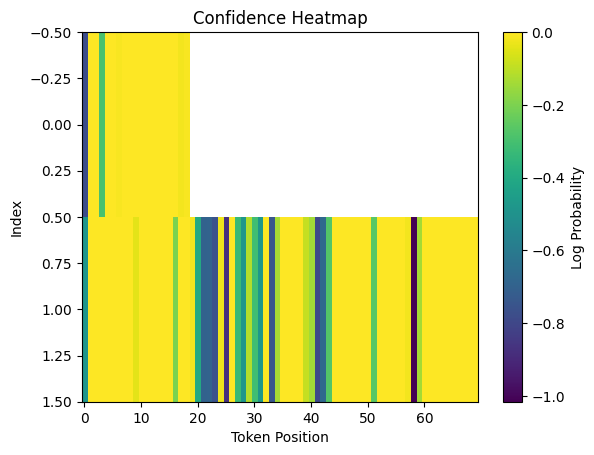

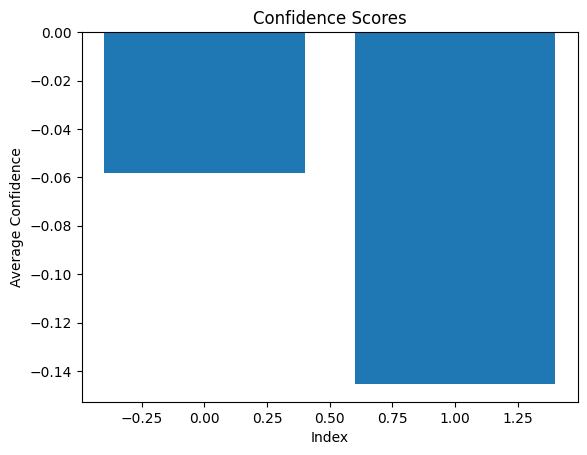

In [228]:
print("Solutions by (ob, cb, child aggreg): ", root_node.ob_log_probs != None, root_node.cb_log_probs != None, root_node.child_aggregation_log_probs != None and root_node.child_aggregation_log_probs != [-1000])
print("Solutions by (ob, cb, child aggreg): ", root_node.ob_answer, " -  ", root_node.cb_answer, " -  ", root_node.child_aggregation_answer)
print("confidences by (ob, cb, child aggreg):", root_node.calculate_avg_log_probs(root_node.ob_log_probs), " -  ", root_node.calculate_avg_log_probs(root_node.cb_log_probs), " -  ", root_node.calculate_avg_log_probs(root_node.child_aggregation_log_probs))
root_node.plot_confidence_heatmap_for_my_solvers() # ob, cb, child_agg
root_node.plot_confidence_bars_for_my_solvers() # ob, cb, child_agg

# Solver Selection based on a ML model ? 

# Preprocessing the tree to match probtree preprocessing

In [125]:
# the dictionary structure should have question as key and the generated tree as value
trees = {question: updated_tree_structure}
trees

{'Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?': {'Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?': {'children': ['What was the typical page count of Weird Tales magazine during the 1930s?',
    'Was Robert E. Howard a frequent contributor to Weird Tales magazine during the 1930s?',
    'Was the fiction magazine in which Robert E. Howard wrote in 1930s primarily Weird Tales magazine?'],
   'children_sum_scores': [-2.04336368615382,
    -0.7338265208047,
    -5.4407544111175],
   'children_log_probs_lengths': [18, 20, 22]}}}

In [126]:
new_trees_format = {}

for key, value in trees.items():
    print(f"Question: {key}")
    new_trees_format[key] = {}
    for node, data in value.items():
        # Calculate the score for the parent node based on the children scores, just by summing them / total length
        # Now we do it by adding all of them and normalizing at the end. (as if all are generated at once as in prob tree)
        # TODO:: may change this to some other calculation which is more powerful.
        score = sum(data['children_sum_scores']) / sum(data['children_log_probs_lengths']) if sum(data['children_log_probs_lengths']) > 0 else -100
        new_trees_format[key][node] = [data['children'], score]

print(new_trees_format)

Question: Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?
{'Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?': {'Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?': [['What was the typical page count of Weird Tales magazine during the 1930s?', 'Was Robert E. Howard a frequent contributor to Weird Tales magazine during the 1930s?', 'Was the fiction magazine in which Robert E. Howard wrote in 1930s primarily Weird Tales magazine?'], -0.13696574363460032]}}


In [127]:
json.dump(new_trees_format, open('question_decompositions.json', 'w'), indent = 2)

In [128]:
import json
import re

raw_data = new_trees_format.copy()
print(len(raw_data.keys()))

def check(question):
    if re.search(r'<\d+>', question):
        return True
tree = {}
for father in raw_data:
    print("----------------------------------------------------------------")
    print("father", father)
    if check(father):
        print("checked father returned true", father)
        print(father)
        continue
    qds = raw_data[father]
    print("qds", qds)
    if qds is None:
        continue
    tree[father] = {}
    for question in qds:
        print("question in qds ::", question)
        if check(question):
            print("checked question returned true ::", question)
            continue
        print("qds[question]", qds[question])
        print("qds[question][0]", qds[question][0])
        if any([x == question for x in qds[question][0]]):
            print("any([x == question for x in qds[question][0]]) returned true")
            print("found !!!")
            exit(1)
            tree[father][question] = [[], None]
        else:
            print("any([x == question for x in qds[question][0]]) returned false")
            tree[father][question] = qds[question]
    if len(qds[question]) > 3:
        print(father)
        print(qds[question])
        print('haha')

# json.dump(tree, open('valid_tree.json', 'w'), indent = 2)
print(len(tree))
question_decompositions = {}
for father in tree:
    qds = tree[father]
    for q in qds:
        if q not in question_decompositions:
            question_decompositions[q] = qds[q]
        else:
            if question_decompositions[q] != qds[q]:
                print(question_decompositions[q])
                print(qds[q])
            else:
                print('haha')


json.dump(question_decompositions, open('tree.json', 'w'), indent = 2)
print(len(tree))

1
----------------------------------------------------------------
father Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?
qds {'Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?': [['What was the typical page count of Weird Tales magazine during the 1930s?', 'Was Robert E. Howard a frequent contributor to Weird Tales magazine during the 1930s?', 'Was the fiction magazine in which Robert E. Howard wrote in 1930s primarily Weird Tales magazine?'], -0.13696574363460032]}
question in qds :: Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?
qds[question] [['What was the typical page count of Weird Tales magazine during the 1930s?', 'Was Robert E. Howard a frequent contributor to Weird Tales magazine during the 1930s?', 'Was the fiction magazine in which Robert E. Howard wrote in 1930s primarily Weird Tales magazine?'], -0.13696574363460032]
qds[question

# 1. Build tree

In [129]:
raw_data = [json.loads(line.strip()) for line in open('../../released_data/hotpotqa__v2_test_random_500.jsonl')]
q2sub_q = json.load(open("./tree.json"))
q2dq = json.load(open("./question_decompositions.json"))
trees = []

def dfs(q, tree):
    # we can have cycles !!!! we must detect them otherwise we will fall in infinite loop :( 
    sons = []
    for sub_q in q2sub_q.get(q, [[]])[0]:
        son_idx = dfs(sub_q, tree)
        sons.append(son_idx)
    idx = len(tree)
    tree.append({
        "idx": idx,
        "question_text": q,
        "sons": sons,
        "qd_logprob": q2sub_q.get(q, [[], None])[1]
    })    
    for son_idx in sons:
        tree[son_idx]["fa"] = idx
    return idx

for item in raw_data:
    question = item['question_text'].strip()
    # just added this since we dont have answers for all 500 questions now, just some of them
    try:
        question = list(q2dq[question].keys())[0]
    except:
        continue
    assert question in q2sub_q, question
    tree = []
    # just added this to overcome the cyclic problem for now
    try:
        dfs(question, tree)
    except:
        continue
    trees.append(tree)

print(trees)
json.dump(trees, open("trees.json", "w"), indent=2)

[[{'idx': 0, 'question_text': 'What was the typical page count of Weird Tales magazine during the 1930s?', 'sons': [], 'qd_logprob': None, 'fa': 3}, {'idx': 1, 'question_text': 'Was Robert E. Howard a frequent contributor to Weird Tales magazine during the 1930s?', 'sons': [], 'qd_logprob': None, 'fa': 3}, {'idx': 2, 'question_text': 'Was the fiction magazine in which Robert E. Howard wrote in 1930s primarily Weird Tales magazine?', 'sons': [], 'qd_logprob': None, 'fa': 3}, {'idx': 3, 'question_text': 'Typically how many pages were in the fiction magazine in which Robert E. Howard wrote in 1930s?', 'sons': [0, 1, 2], 'qd_logprob': -0.13696574363460032}]]


# 2. Run script to get answers

In [130]:
import json
import re
import os
from question_answering import *
from tqdm import tqdm
from parallel import parallel_process_data
from dotenv import load_dotenv
load_dotenv()
key_pool = os.getenv('TOGETHER_API_KEY').split(',')

PROC_NUM = len(key_pool)
cnt = 0

def solve(tree):
    global cnt
    cnt += 1
    print("----------------------------------------------------------------------------------------------------------------------------------------")
    print(cnt)
    #print(tree[-1])
    try:
        for node in tree:
            print("node", node)

            question = node["question_text"].strip()
            ref_tokens = re.findall(r"<\d+>", question)
            topic_entities = []
            print("question, ref_tokens", question, ref_tokens)
            # return
            for ref_token in ref_tokens:
                if "fa" in node and int(ref_token[1:-1]) <= len(tree[node["fa"]]["sons"]):
                    ref_idx = tree[node["fa"]]["sons"][int(ref_token[1:-1])-1]
                    print("ref_idx", ref_idx)
                    if "answer" in tree[ref_idx]:
                        question = question.replace(ref_token, tree[ref_idx]["answer"][0])
                        topic_entities.append(tree[ref_idx]["answer"][0])
            node["question"] = question
            node["cb_answer"] = get_cb_answer(question)
            print('node["cb_answer"]', node["cb_answer"], "\n")
            if len(node["sons"]) == 0:
                node["ob_answer"] = get_singlehop_ob_answer(question, topic_entities)
                print('node["ob_answer"]', node["ob_answer"], "\n")
                #print(node["ob_answer"])
                node["answer"] = aggregate_singlehop_answer(node["cb_answer"], node["ob_answer"])
                print('node["answer"]', node["answer"], "\n")
            else:
                node["ob_answer"] = get_multihop_ob_answer(node, tree)
                print('node["ob_answer"]', node["ob_answer"], "\n")
                #print(node["ob_answer"])
                node["child_answer"], node["answer"] = aggregate_multihop_answer(node, tree)
                print('node["child_answer"]', node["child_answer"], "\n")
                print('node["answer"]', node["answer"], "\n")
    except Exception as e:
        print("ERROR CASE", e)
        print(tree[-1])
        raise e


trees = json.load(open("trees.json", "r"))
print("Total: %d | Start Processing..."%len(trees))
parallel_process_data(trees, solve, PROC_NUM)


print("END")
os.makedirs("results", exist_ok=True)
json.dump(trees, open("results/test.json", "w"), indent=2)

Total: 1 | Start Processing...
----------------------------------------------------------------------------------------------------------------------------------------
1
node {'idx': 0, 'question_text': 'What was the typical page count of Weird Tales magazine during the 1930s?', 'sons': [], 'qd_logprob': None, 'fa': 3}
question, ref_tokens What was the typical page count of Weird Tales magazine during the 1930s? []
Please answer the following question by breaking it down step-by-step, and ensure that your response is formatted according to the example provided below.

The exact format should be:
[Explanation]. So the answer is: [Answer]

Example Format:

Q: Jeremy Theobald and Christopher Nolan share what profession?
A: Jeremy Theobald is an actor and producer. Christopher Nolan is a director, producer, and screenwriter. Therefore, they both share the profession of being a producer. So the answer is: producer.

Q: How many episodes were in the South Korean television series in which Ry

# 3. Evaluate

In [45]:
import json

import json
from tqdm import tqdm
from termcolor import colored
from evaluate import update_answer
import math
# import re

q2a = {}
raw_data = [json.loads(line.strip()) for line in open('../../released_data/hotpotqa__v2_test_random_500.jsonl')]
q2dq = json.load(open("./question_decompositions.json"))
q2gold = {}
for item in raw_data:
    try:
        question = item['question_text'].strip()
        question = list(q2dq[question].keys())[0]
        # should add it later but run prompts again 
        # question = re.sub(r'\s+', ' ', question)
        gold = item['answers_objects'][0]['spans'][0]
        q_type = item["type"]
        q2gold[question] = (gold, q_type)
    except Exception as e:
        # If question not found in question_decompositions, this means something went wrong in the proccess maybe in json parsing in prev steps of tree generation
        print("ERROR CASE", e)

trees = json.load(open("results/test.json", "r"))
metrics = {}
for q_type in ["all", "bridge", "comparison"]:
    metrics[q_type] = {'em': 0, 'f1': 0, 'prec': 0, 'recall': 0, 'N': 0}

print(len(trees))
for i, tree in enumerate(trees):
    node = tree[-1]
    question, answer = node["question"], node["answer"][0]
    gold, q_type = q2gold[question]
    print("question", question)
    print("question type", q_type)
    print("answer", answer)
    print("gold", gold)
    print("------------------------------")
    q2a[question] = (i, answer, gold)
    em, f1, prec, recall = update_answer(metrics["all"], answer, gold)
    update_answer(metrics[q_type], answer, gold)

for q_type in ["all", "bridge", "comparison"]:
    print(q_type)
    print(metrics[q_type]['N'])

    for k in metrics[q_type].keys():
        metrics[q_type][k] /= metrics[q_type]['N']
    print(metrics[q_type])


json.dump(q2a, open("q2a.json", "w"), indent=2)

ERROR CASE "What is the nationality of the foreign born victim of Singapore's caning punishment before Oliver Fricker experienced the same?"
ERROR CASE 'Dorian Gray is the main character of what philosophical novel whose editor feared the story was indecent, and deleted roughly five hundred words before publication?'
ERROR CASE 'Who wrote the 1970 international hit song Murray Head is most recognized for?'
ERROR CASE 'Where was the match held where Chicharito scored goals along with Antonio Valencia and Dimitar Berbatov?'
ERROR CASE 'Where was Nexon who was composed by Adam Gubman located at?'
ERROR CASE 'What event in 1920 was established by the director of the play "The Miracle?"'
ERROR CASE 'This annual event held in several major cities in Finland is one of many all-night arts festival whose name is given to areas of high latitude in the weeks around what?'
ERROR CASE "Chun Woo-hee's notable films include a South Korean horror film about  a policeman who investigates a series of my

ZeroDivisionError: division by zero

# DRAFTS 

In [ ]:
from question_answering import bm25_search
import re

class ExternalKnowledgeInjectionAction(Action):
    def __init__(self, external_knowledge_query_function=bm25_search):
        self.external_knowledge_query_function = external_knowledge_query_function
        self.k = 5 # Number of external knowledge sources to retrieve

    # TODO:: what if we have <1> in the question ?? we should replace it with the answer of the child. but what if its not answered yet ??
    def execute(self, node):
        """Inject external knowledge into the node."""
        
        # # Check if the node contains <1>, <2>, etc. placeholders, which indicate dependencies on other nodes
        # placeholders = re.findall(r"<(\d+)>", node.question)
        # # If placeholders are present, assert that the node still have dependencies and return an error message
        # assert not placeholders, f"Node '{node.question}' contains placeholders that are not yet resolved."
        
        external_knowledge = self.external_knowledge_query_function(node.question, self.k)
        # we have output looking like for hotpotqa es: [{title: "title", text: "text"}]
        node.external_knowledge = external_knowledge